# Definition
- diapad is at F3
- sr91 is upstream SR-PPAC of FE9
- sr92 is downstream SR-PPAC of FE9
- src1 is upstream SR-PPAC of FE12
- src2 is downstream SR-PPAC of FE12
- sr11 is upstream SR-PPAC of S1
- sr12 is downstream SR-PPAC of S1
- f5ppac1a is one of upstream SR-PPAC of F5
- f5ppac1b is another upstream SR-PPAC of F5
- f5ppac2a is one of downstream SR-PPAC of F5
- f5ppac2b is another downstream SR-PPAC of F5
- f5track_A is X angle
- f5track_B is Y angle

In [26]:
from pyspark.sql import SparkSession, Column, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, IntegerType,DoubleType
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyspark.sql.functions import size
from make_SRPPAC_prm import dqlr_calib_data
import matplotlib.cm as cm
import matplotlib.colors
from spark_c0c1c2 import srppac_c0c1c2
from pyspark.sql.functions import abs
from pyspark.sql.functions import when, col
from DtDl import MonotoneTableConverter
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import math
import statistics

spark = SparkSession.builder.appName("testApp").getOrCreate()

#Read the parquet file
df=spark.read.parquet("chkbldoptics0107.parquet")
print(df.count())
df.show(3,truncate=False)

244401
+-------+---------+--------------+----------------------+-----------------------+---------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+----------+----------+---------------+----------+----------+---------------+----------+----------+----

# Event selection
- Exclude events with empty or defective data.

In [27]:
############ FE9 PPAC ###################
df_s1=df.select("event_num","diapad_timing","sr11_x_cal_timing","sr11_x_cal_charge","sr11_x_cal_id",
                 "sr11_y_cal_timing","sr11_y_cal_charge","sr11_y_cal_id",
                 "sr12_x_cal_timing","sr12_x_cal_charge","sr12_x_cal_id",
                 "sr12_y_cal_timing","sr12_y_cal_charge","sr12_y_cal_id",
                 "f5ppac1a_TAnode","f5ppac1b_TAnode","f5ppac2a_TAnode","f5ppac2b_TAnode","f5track_X")

df_s1 = df_s1.filter(
    (F.col("diapad_timing").isNotNull()) &
    (F.size("diapad_timing") > 0) &
    (F.col("sr11_x_cal_timing").isNotNull()) &
    (F.size("sr11_x_cal_timing") > 0) &
    (F.col("sr11_x_cal_charge").isNotNull()) &
    (F.size("sr11_x_cal_charge") > 1) &
    (F.col("sr11_x_cal_id").isNotNull()) &
    (F.size("sr11_x_cal_id") > 1) &
    (F.col("sr11_y_cal_timing").isNotNull()) &
    (F.size("sr11_y_cal_timing") > 0) &
    (F.col("sr11_y_cal_charge").isNotNull()) &
    (F.size("sr11_y_cal_charge") > 1) &
    (F.col("sr11_y_cal_id").isNotNull()) &
    (F.size("sr11_y_cal_id") > 1) &
    (F.col("sr12_x_cal_timing").isNotNull()) &
    (F.size("sr12_x_cal_timing") > 0) &
    (F.col("sr12_x_cal_charge").isNotNull()) &
    (F.size("sr12_x_cal_charge") > 1) &
    (F.col("sr12_x_cal_id").isNotNull()) &
    (F.size("sr12_x_cal_id") > 1) &
    (F.col("sr12_y_cal_timing").isNotNull()) &
    (F.size("sr12_y_cal_timing") > 0) &
    (F.col("sr12_y_cal_charge").isNotNull()) &
    (F.size("sr12_y_cal_charge") > 1) &
    (F.col("sr12_y_cal_id").isNotNull()) &
    (F.size("sr12_y_cal_id") > 1) &
    (F.col("f5ppac1a_TAnode").isNotNull()) &
    (F.col("f5ppac1b_TAnode").isNotNull()) &
    (F.col("f5ppac2a_TAnode").isNotNull()) &
    (F.col("f5ppac2b_TAnode").isNotNull()) &
    (F.col("f5track_X").isNotNull()) 
)
print(df_s1.count())

13594


# Calculation of TOF for F3 ~ F5
- Calculate timing from one F3 diamond detector.
- Calculate timing by taking the average from two F5 PPACs.
- The difference is the TOF of F3 to F5.
- Output 5 events.

In [28]:
df_tof35=df_s1.withColumn("f5_T",(F.col("f5ppac1a_TAnode")+F.col("f5ppac1b_TAnode")+F.col("f5ppac2a_TAnode")+F.col("f5ppac2b_TAnode"))/4)
df_tof35=df_tof35.withColumn("tof35",F.col("f5_T")-F.col("diapad_timing").getItem(0))
df_tof35.select("tof35").show(5,truncate=False)

+------------------+
|tof35             |
+------------------+
|2657.3977127075195|
|2657.4643592834473|
|2657.317886352539 |
|2656.3587188720703|
|2656.9206924438477|
+------------------+
only showing top 5 rows


# TOF F3〜5 vs. F5-X
- Specify the display range and plot TOF F3~5 versus F5-X.

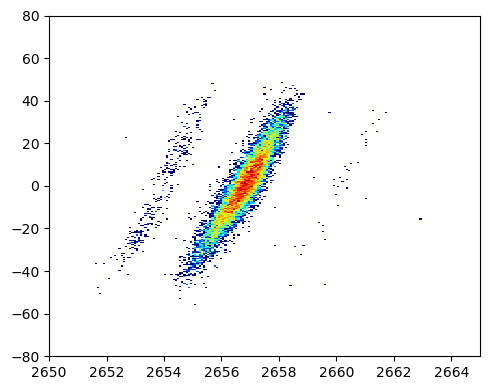

In [29]:
df_tof35=df_tof35.filter(F.col("tof35").isNotNull())
tof35=df_tof35.select("tof35").toPandas().values.flatten()
f5track=df_tof35.select("f5track_X").toPandas().values.flatten()


fig, ax = plt.subplots(figsize=(5, 4))
ax.hist2d(tof35,f5track,bins=[np.linspace(2650,2665,200),np.linspace(-80,80,320)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
ax.set_xlim(2650,2665)
plt.tight_layout()
plt.show()

# Event plot of PID35(Particle IDentification of F3~F5)
- Convert the x-position detected at f5(depends on the momentum) to PID(correlats with A/Q?)

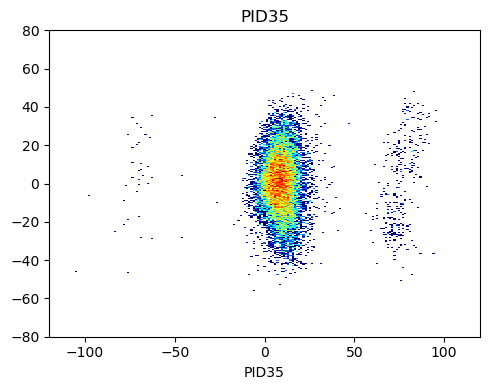

In [30]:
df_pid35=df_tof35.withColumn("pid35",F.col("f5track_X")-F.lit(23.676)*(F.col("tof35")-F.lit(2658))-F.lit(20))
pid35=df_pid35.select("pid35").toPandas().values.flatten()
f5track=df_tof35.select("f5track_X").toPandas().values.flatten()
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist2d(pid35,f5track,bins=[np.linspace(-120,120,200),np.linspace(-80,80,320)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
ax.set_title("PID35")
ax.set_xlabel("PID35")
plt.tight_layout()
plt.show()
                             

# PID35 event filtering
- Plot events where the value of PID35 is -25<=PID35<=25.

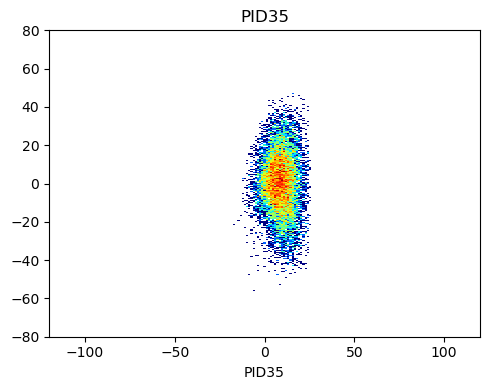

In [31]:
df_pidgate=df_pid35.filter(abs(F.col("pid35"))<=25)
pid35=df_pidgate.select("pid35").toPandas().values.flatten()
f5track=df_pidgate.select("f5track_X").toPandas().values.flatten()
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist2d(pid35,f5track,bins=[np.linspace(-120,120,200),np.linspace(-80,80,320)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
ax.set_title("PID35")
ax.set_xlabel("PID35")
plt.tight_layout()
plt.show()

# TOF F3〜5 vs. TOF F3〜S1
- Calculate the timing of S1 from the average of the timing of upstream of S1 and downstream of S1.
- The difference between them is the TOF of F3~S1.
- Print the number of TOF F3〜S1.

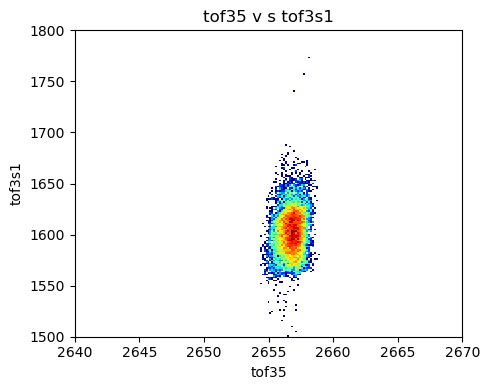

In [32]:
df_tof3s1=df_pidgate.withColumn("tof3s1",(F.col("sr11_x_cal_timing").getItem(0)+(F.col("sr12_x_cal_timing").getItem(0))/2-F.col("diapad_timing").getItem(0)))
tof3s1=df_tof3s1.select("tof3s1").toPandas().values.flatten()
tof35=df_tof3s1.select("tof35").toPandas().values.flatten()
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist2d(tof35,tof3s1,bins=[np.linspace(2640,2670,200),np.linspace(1500,1800,200)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
ax.set_title("tof35 v s tof3s1")
ax.set_xlabel("tof35")
ax.set_ylabel("tof3s1")
plt.tight_layout()
plt.show()


In [33]:
print(df_tof3s1.count())


13083


# Split the events.
- Select the x and y ID, timing, and charge information for upstream and downstream of S1.
- Split them into columns.

In [34]:
df_tval=df_pidgate
df_sr11x=df_tval.select("event_num","sr11_x_cal_timing","sr11_x_cal_charge","sr11_x_cal_id")
df_sr11y=df_tval.select("event_num","sr11_y_cal_timing","sr11_y_cal_charge","sr11_y_cal_id")
df_sr12x=df_tval.select("event_num","sr12_x_cal_timing","sr12_x_cal_charge","sr12_x_cal_id")
df_sr12y=df_tval.select("event_num","sr12_y_cal_timing","sr12_y_cal_charge","sr12_y_cal_id")

########## exploded data for sr11x ###################
# Zip the charge and id columns into a struct so they stay together when exploded
df_zipped = df_sr11x.withColumn("zipped", F.arrays_zip(F.col("sr11_x_cal_charge"),F.col("sr11_x_cal_timing"), F.col("sr11_x_cal_id")))
# Explode the zipped array to handle individual elements
df_exploded = df_zipped.withColumn("exploded", F.explode("zipped"))
# Split the exploded struct back into separate columns for charge and id
df_split = df_exploded.withColumn("sr11x_Atot", F.col("exploded.sr11_x_cal_charge")) \
                          .withColumn("sr11x_Atiming", F.col("exploded.sr11_x_cal_timing")) \
                          .withColumn("sr11x_Aid", F.col("exploded.sr11_x_cal_id"))
df_s1x_exp=df_split.select("event_num","sr11x_Atot","sr11x_Atiming","sr11x_Aid")
########################### exploded data for y #####################
# Zip the charge and id columns into a struct so they stay together when exploded
df_zipped = df_sr11y.withColumn("zipped", F.arrays_zip(F.col("sr11_y_cal_charge"),F.col("sr11_y_cal_timing"), F.col("sr11_y_cal_id")))
# Explode the zipped array to handle individual elements
df_exploded = df_zipped.withColumn("exploded", F.explode("zipped"))
# Split the exploded struct back into separate columns for charge and id
df_split = df_exploded.withColumn("sr11y_Atot", F.col("exploded.sr11_y_cal_charge")) \
                          .withColumn("sr11y_Atiming", F.col("exploded.sr11_y_cal_timing")) \
                          .withColumn("sr11y_Aid", F.col("exploded.sr11_y_cal_id"))
df_s1y_exp=df_split.select("event_num","sr11y_Atot","sr11y_Atiming","sr11y_Aid")
########## exploded data for sr12x ###################
# Zip the charge and id columns into a struct so they stay together when exploded
df_zipped = df_sr12x.withColumn("zipped", F.arrays_zip(F.col("sr12_x_cal_charge"),F.col("sr12_x_cal_timing"), F.col("sr12_x_cal_id")))
# Explode the zipped array to handle individual elements
df_exploded = df_zipped.withColumn("exploded", F.explode("zipped"))
# Split the exploded struct back into separate columns for charge and id
df_split = df_exploded.withColumn("sr12x_Atot", F.col("exploded.sr12_x_cal_charge")) \
                          .withColumn("sr12x_Atiming", F.col("exploded.sr12_x_cal_timing")) \
                          .withColumn("sr12x_Aid", F.col("exploded.sr12_x_cal_id"))
df_s2x_exp=df_split.select("event_num","sr12x_Atot","sr12x_Atiming","sr12x_Aid")
########################### exploded data for y #####################
# Zip the charge and id columns into a struct so they stay together when exploded
df_zipped = df_sr12y.withColumn("zipped", F.arrays_zip(F.col("sr12_y_cal_charge"),F.col("sr12_y_cal_timing"), F.col("sr12_y_cal_id")))
# Explode the zipped array to handle individual elements
df_exploded = df_zipped.withColumn("exploded", F.explode("zipped"))
# Split the exploded struct back into separate columns for charge and id
df_split = df_exploded.withColumn("sr12y_Atot", F.col("exploded.sr12_y_cal_charge")) \
                          .withColumn("sr12y_Atiming", F.col("exploded.sr12_y_cal_timing")) \
                          .withColumn("sr12y_Aid", F.col("exploded.sr12_y_cal_id"))
df_s2y_exp=df_split.select("event_num","sr12y_Atot","sr12y_Atiming","sr12y_Aid")


# Output 4 events
- Output the charge, ID, and timing of Q0, Q1, and Q2 in the SR-PPAC upstream of S1.

In [35]:
df_sorteds1x=srppac_c0c1c2(df_s1x_exp, "sr11x", "sr11x_Atot", "sr11x_Atiming", "sr11x_Aid","sr11x_Atot")
df_sorteds1y=srppac_c0c1c2(df_s1y_exp, "sr11y", "sr11y_Atot", "sr11y_Atiming", "sr11y_Aid","sr11y_Atot")
df_sorteds2x=srppac_c0c1c2(df_s2x_exp, "sr12x", "sr12x_Atot", "sr12x_Atiming", "sr12x_Aid","sr12x_Atot")
df_sorteds2y=srppac_c0c1c2(df_s2y_exp, "sr12y", "sr12y_Atot", "sr12y_Atiming", "sr12y_Aid","sr12y_Atot")
df_sorteds1y.show(4,truncate=False)

+---------+---------+--------+---------+--------+--------+--------+----------+----------+----------+
|event_num|sr11yc0  |sr11yc1 |sr11yc2  |sr11yid0|sr11yid1|sr11yid2|sr11yt0   |sr11yt1   |sr11yt2   |
+---------+---------+--------+---------+--------+--------+--------+----------+----------+----------+
|24       |47.901283|47.80938|27.872566|19      |20      |18      |-683.7543 |-683.71704|-679.9524 |
|41       |52.461723|46.57951|37.53931 |31      |30      |32      |-695.36487|-694.71716|-694.56085|
|42       |47.882145|43.37669|27.379473|44      |45      |43      |-684.27466|-683.20374|-679.97754|
|47       |47.880383|43.43965|27.301163|21      |20      |22      |-689.7105 |-688.911  |-686.1806 |
+---------+---------+--------+---------+--------+--------+--------+----------+----------+----------+
only showing top 4 rows


# Remove rows containing NULL (including rows converted from NULL + NaN) of S1 
- Convert NaN to NULL
- Remove NULL events
- Remove in the same way(upstream and downstream X and Y of S1).
- Output the number of each "clean" event.

In [36]:

################################
# NaN を NULL に変換（すべての列に対して）
df_no_nan = df_sorteds1x.select([
    when(~col(c).isNotNull() | (col(c).isNaN() if dict(df_sorteds1x.dtypes)[c] == 'double' else False), None).otherwise(col(c)).alias(c)
    for c in df_sorteds1x.columns
])
# NULL (もともと NULL + NaNを変換したもの) を含む行を削除
df_sorteds1x_clean = df_no_nan.dropna()
##############################
df_no_nan = df_sorteds1y.select([
    when(~col(c).isNotNull() | (col(c).isNaN() if dict(df_sorteds1y.dtypes)[c] == 'double' else False), None).otherwise(col(c)).alias(c)
    for c in df_sorteds1y.columns
])
df_sorteds1y_clean = df_no_nan.dropna()

################################
# NaN を NULL に変換（すべての列に対して）
df_no_nan = df_sorteds2x.select([
    when(~col(c).isNotNull() | (col(c).isNaN() if dict(df_sorteds2x.dtypes)[c] == 'double' else False), None).otherwise(col(c)).alias(c)
    for c in df_sorteds2x.columns
])
# NULL (もともと NULL + NaNを変換したもの) を含む行を削除
df_sorteds2x_clean = df_no_nan.dropna()
##############################
df_no_nan = df_sorteds2y.select([
    when(~col(c).isNotNull() | (col(c).isNaN() if dict(df_sorteds2y.dtypes)[c] == 'double' else False), None).otherwise(col(c)).alias(c)
    for c in df_sorteds2y.columns
])
df_sorteds2y_clean = df_no_nan.dropna()

print(df_sorteds1x_clean.count())
print(df_sorteds1y_clean.count())
print(df_sorteds2x_clean.count())
print(df_sorteds2y_clean.count())

12081
12362
11860
12229


# Plot the ToT width and the number of Q0, Q1, and Q2 events for all SR-PPACs in S1
- Create a histogram for ToT width and count.
- Create a histogram for the  X and Y plane of the upstream and downstream in S1.

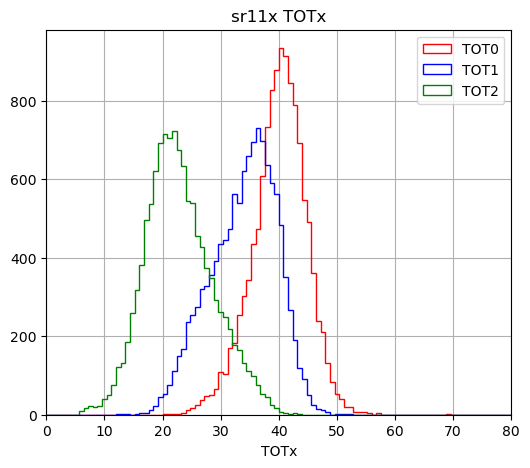

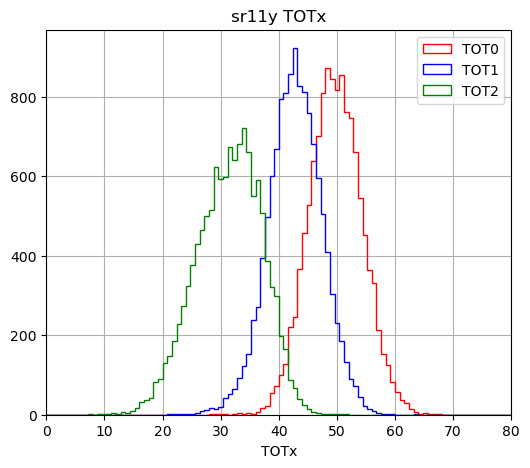

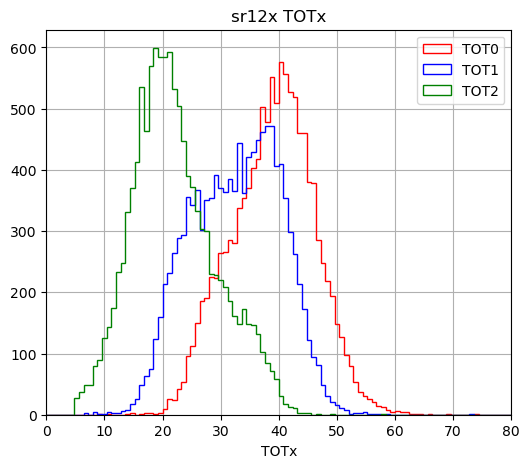

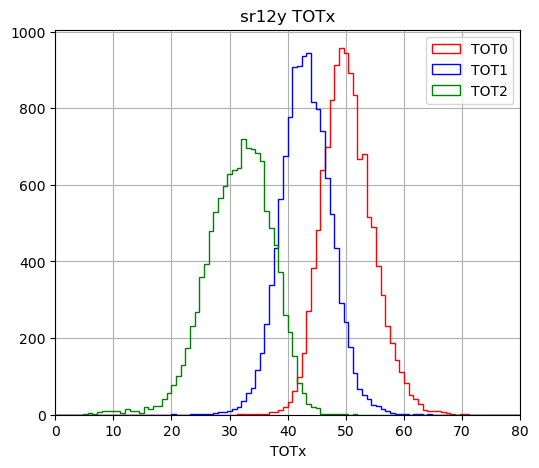

In [37]:
xTOT0=df_sorteds1x_clean.select("sr11xc0").alias("TOT0").toPandas().values.flatten()
xTOT1=df_sorteds1x_clean.select("sr11xc1").alias("TOT0").toPandas().values.flatten()
xTOT2=df_sorteds1x_clean.select("sr11xc2").alias("TOT0").toPandas().values.flatten()
fig,ax=plt.subplots(figsize=(6,5))
ax.hist(xTOT0,bins=100,range=(0,80),histtype="step",color='red',label='TOT0')
ax.hist(xTOT1,bins=100,range=(0,80),histtype="step",color='blue',label='TOT1')
ax.hist(xTOT2,bins=100,range=(0,80),histtype="step",color='green',label='TOT2')
ax.set_xlabel('TOTx')
ax.set_title('sr11x TOTx')
ax.set_xlim(0,80)
plt.grid()
plt.legend()
plt.show()
yTOT0=df_sorteds1y_clean.select("sr11yc0").alias("TOT0").toPandas().values.flatten()
yTOT1=df_sorteds1y_clean.select("sr11yc1").alias("TOT0").toPandas().values.flatten()
yTOT2=df_sorteds1y_clean.select("sr11yc2").alias("TOT0").toPandas().values.flatten()
fig,ax=plt.subplots(figsize=(6,5))
ax.hist(yTOT0,bins=100,range=(0,80),histtype="step",color='red',label='TOT0')
ax.hist(yTOT1,bins=100,range=(0,80),histtype="step",color='blue',label='TOT1')
ax.hist(yTOT2,bins=100,range=(0,80),histtype="step",color='green',label='TOT2')
ax.set_xlabel('TOTx')
ax.set_title('sr11y TOTx')
ax.set_xlim(0,80)
plt.grid()
plt.legend()
plt.show()
xTOT0=df_sorteds2x_clean.select("sr12xc0").alias("TOT0").toPandas().values.flatten()
xTOT1=df_sorteds2x_clean.select("sr12xc1").alias("TOT0").toPandas().values.flatten()
xTOT2=df_sorteds2x_clean.select("sr12xc2").alias("TOT0").toPandas().values.flatten()
fig,ax=plt.subplots(figsize=(6,5))
ax.hist(xTOT0,bins=100,range=(0,80),histtype="step",color='red',label='TOT0')
ax.hist(xTOT1,bins=100,range=(0,80),histtype="step",color='blue',label='TOT1')
ax.hist(xTOT2,bins=100,range=(0,80),histtype="step",color='green',label='TOT2')
ax.set_xlabel('TOTx')
ax.set_title('sr12x TOTx')
ax.set_xlim(0,80)
plt.grid()
plt.legend()
plt.show()
yTOT0=df_sorteds2y_clean.select("sr12yc0").alias("TOT0").toPandas().values.flatten()
yTOT1=df_sorteds2y_clean.select("sr12yc1").alias("TOT0").toPandas().values.flatten()
yTOT2=df_sorteds2y_clean.select("sr12yc2").alias("TOT0").toPandas().values.flatten()
fig,ax=plt.subplots(figsize=(6,5))
ax.hist(yTOT0,bins=100,range=(0,80),histtype="step",color='red',label='TOT0')
ax.hist(yTOT1,bins=100,range=(0,80),histtype="step",color='blue',label='TOT1')
ax.hist(yTOT2,bins=100,range=(0,80),histtype="step",color='green',label='TOT2')
ax.set_xlabel('TOTx')
ax.set_title('sr12y TOTx')
ax.set_xlim(0,80)
plt.grid()
plt.legend()
plt.show()

# Plot Charge comparison of Q0, QL, and QR of the upstream of S1.
- Q_L is the ID that is one greater than id0, Q_R is the ID that is one less than id0.
- Plot (TOT0-TOTLorR)/(TOT0+TOTLorR)

xq0l_sr11_0107
ファイル './prm/srppac/xq0l_sr11_0107.dat' に保存しました。


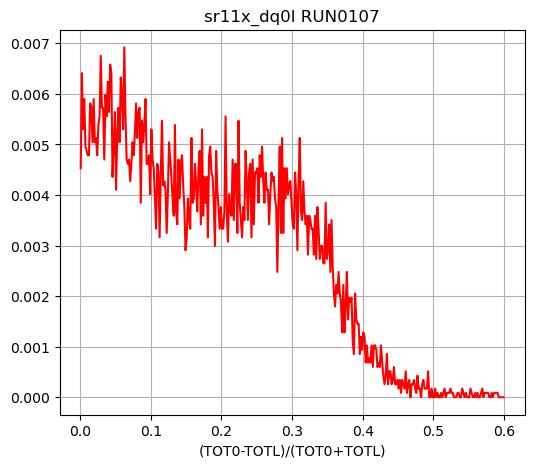

xq0r_sr11_0107
ファイル './prm/srppac/xq0r_sr11_0107.dat' に保存しました。


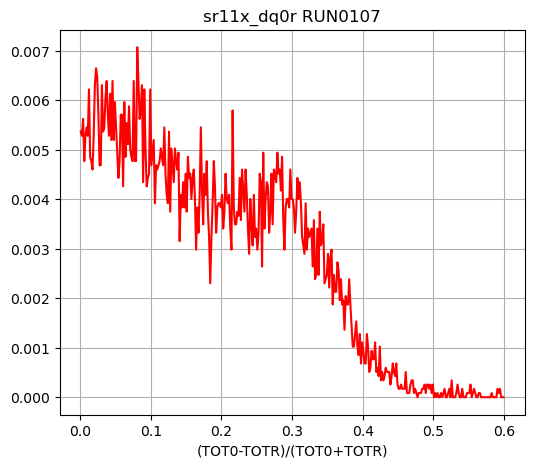

yq0l_sr11_0107
ファイル './prm/srppac/yq0l_sr11_0107.dat' に保存しました。


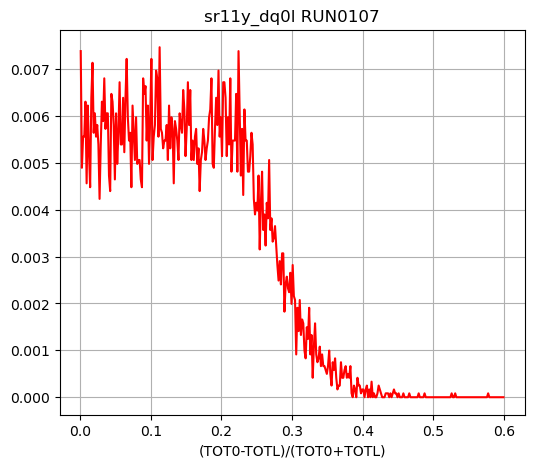

yq0r_sr11_0107
ファイル './prm/srppac/yq0r_sr11_0107.dat' に保存しました。


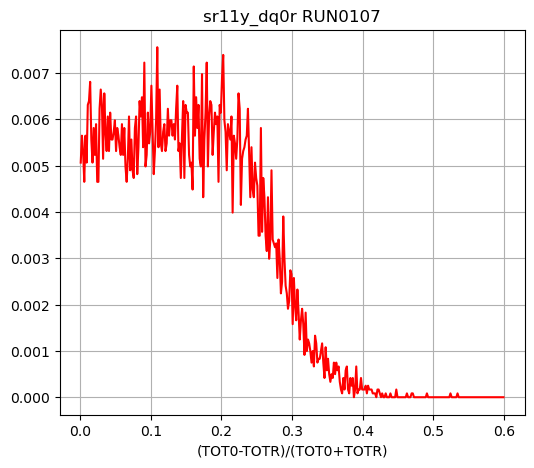

In [38]:

df_xq0l=df_sorteds1x_clean.withColumn("xq0l",F.when(F.col("sr11xid1")==F.col("sr11xid0")+1,
                                          (F.col("sr11xc0")-F.col("sr11xc1"))/(F.col("sr11xc0")+F.col("sr11xc1")))\
                            .when(F.col("sr11xid2")==F.col("sr11xid0")+1,
                                              (F.col("sr11xc0")-F.col("sr11xc2"))/(F.col("sr11xc0")+F.col("sr11xc2")))\
                            .otherwise(float('nan')))

df_xq0l=df_xq0l.withColumn("xlm",F.when(F.col("sr11xid1")==F.col("sr11xid0")+1,
                                          (F.col("sr11xc0")-F.col("sr11xc1")))\
                            .when(F.col("sr11xid2")==F.col("sr11xid0")+1,
                                              (F.col("sr11xc0")-F.col("sr11xc2")))\
                            .otherwise(float('nan')))

df_xq0r=df_xq0l.withColumn("xq0r",F.when(F.col("sr11xid1")==F.col("sr11xid0")-1,
                                          (F.col("sr11xc0")-F.col("sr11xc1"))/(F.col("sr11xc0")+F.col("sr11xc1")))\
                            .when(F.col("sr11xid2")==F.col("sr11xid0")-1,
                                              (F.col("sr11xc0")-F.col("sr11xc2"))/(F.col("sr11xc0")+F.col("sr11xc2")))\
                            .otherwise(float('nan')))
df_xq0lr1=df_xq0r.withColumn("xrm",F.when(F.col("sr11xid1")==F.col("sr11xid0")-1,
                                          (F.col("sr11xc0")-F.col("sr11xc1")))\
                            .when(F.col("sr11xid2")==F.col("sr11xid0")-1,
                                              (F.col("sr11xc0")-F.col("sr11xc2")))\
                            .otherwise(float('nan')))

df_yq0l=df_sorteds1y_clean.withColumn("yq0l",F.when(F.col("sr11yid1")==F.col("sr11yid0")+1,
                                          (F.col("sr11yc0")-F.col("sr11yc1"))/(F.col("sr11yc0")+F.col("sr11yc1")))\
                            .when(F.col("sr11yid2")==F.col("sr11yid0")+1,
                                              (F.col("sr11yc0")-F.col("sr11yc2"))/(F.col("sr11yc0")+F.col("sr11yc2")))\
                            .otherwise(float('nan')))
df_yq0l=df_yq0l.withColumn("ylm",F.when(F.col("sr11yid1")==F.col("sr11yid0")+1,
                                          (F.col("sr11yc0")-F.col("sr11yc1")))\
                            .when(F.col("sr11yid2")==F.col("sr11yid0")+1,
                                              (F.col("sr11yc0")-F.col("sr11yc2")))\
                            .otherwise(float('nan')))

df_yq0r=df_yq0l.withColumn("yq0r",F.when(F.col("sr11yid1")==F.col("sr11yid0")-1,
                                          (F.col("sr11yc0")-F.col("sr11yc1"))/(F.col("sr11yc0")+F.col("sr11yc1")))\
                            .when(F.col("sr11yid2")==F.col("sr11yid0")-1,
                                              (F.col("sr11yc0")-F.col("sr11yc2"))/(F.col("sr11yc0")+F.col("sr11yc2")))\
                            .otherwise(float('nan')))

df_yq0lr1=df_yq0r.withColumn("yrm",F.when(F.col("sr11yid1")==F.col("sr11yid0")-1,
                                          (F.col("sr11yc0")-F.col("sr11yc1")))\
                            .when(F.col("sr11yid2")==F.col("sr11yid0")-1,
                                              (F.col("sr11yc0")-F.col("sr11yc2")))\
                            .otherwise(float('nan')))

#df_xq0r.select("xq0r").show(20,truncate=False)
xq0l=df_xq0lr1.select("xq0l").alias("charge").toPandas().values.flatten()
xq0r=df_xq0lr1.select("xq0r").alias("charge").toPandas().values.flatten()
yq0l=df_yq0lr1.select("yq0l").alias("charge").toPandas().values.flatten()
yq0r=df_yq0lr1.select("yq0r").alias("charge").toPandas().values.flatten()

runname="0107"
histy_x,hx_contents,filenamexq0l=dqlr_calib_data(xq0l,"xq0l_sr11_"+runname,h_range=(0,0.6),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTL)/(TOT0+TOTL)')
ax.set_title('sr11x_dq0l RUN'+runname)
plt.grid()
plt.show()

histy_x,hx_contents,filenamexq0l=dqlr_calib_data(xq0r,"xq0r_sr11_"+runname,h_range=(0,0.6),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTR)/(TOT0+TOTR)')
ax.set_title('sr11x_dq0r RUN'+runname)
plt.grid()
plt.show()

histy_x,hx_contents,filenamexq0l=dqlr_calib_data(yq0l,"yq0l_sr11_"+runname,h_range=(0,0.6),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTL)/(TOT0+TOTL)')
ax.set_title('sr11y_dq0l RUN'+runname)
plt.grid()
plt.show()

histy_x,hx_contents,filenamexq0l=dqlr_calib_data(yq0r,"yq0r_sr11_"+runname,h_range=(0,0.6),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTR)/(TOT0+TOTR)')
ax.set_title('sr11y_dq0r RUN'+runname)
plt.grid()
plt.show()


# Plot Charge comparison of Q0, QL, and QR of the downstream of S1.
- Q_L is the ID that is one greater than id0, Q_R is the ID that is one less than id0.
- Plot (TOT0-TOTLorR)/(TOT0+TOTLorR)

xq0l_sr12_0107
ファイル './prm/srppac/xq0l_sr12_0107.dat' に保存しました。


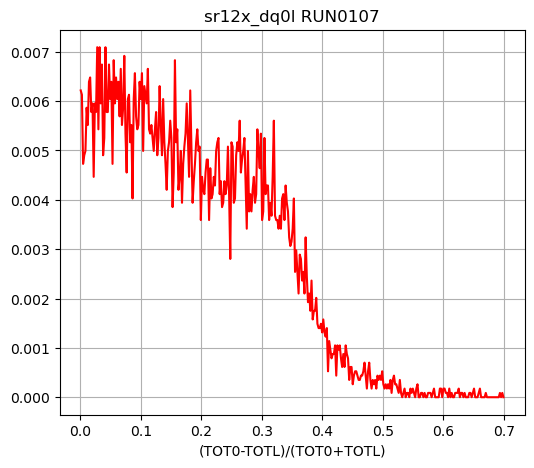

xq0r_sr12_0107
ファイル './prm/srppac/xq0r_sr12_0107.dat' に保存しました。


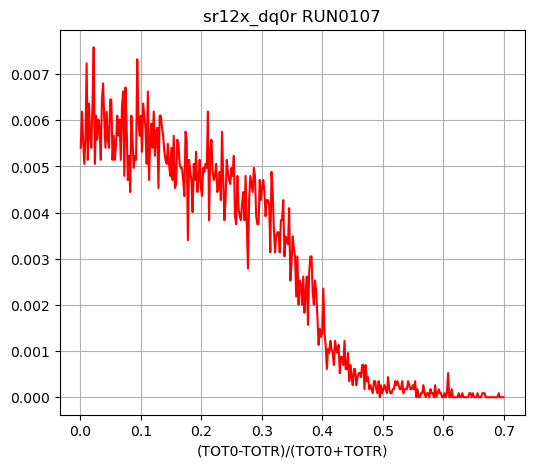

yq0l_sr12_0107
ファイル './prm/srppac/yq0l_sr12_0107.dat' に保存しました。


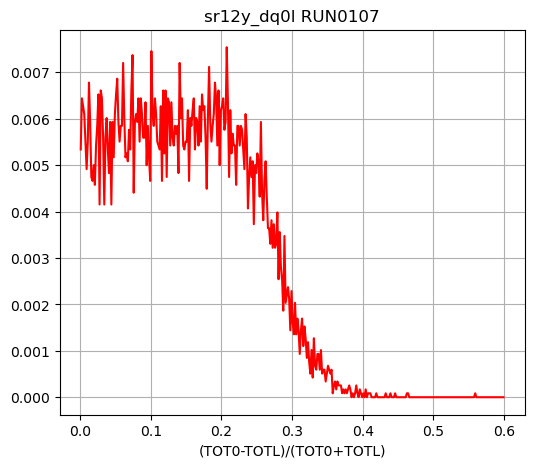

yq0r_sr12_0107
ファイル './prm/srppac/yq0r_sr12_0107.dat' に保存しました。


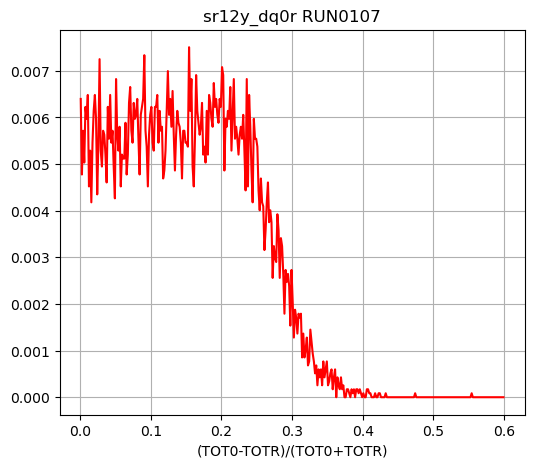

In [39]:
df_xq0l=df_sorteds2x_clean.withColumn("xq0l",F.when(F.col("sr12xid1")==F.col("sr12xid0")+1,
                                          (F.col("sr12xc0")-F.col("sr12xc1"))/(F.col("sr12xc0")+F.col("sr12xc1")))\
                            .when(F.col("sr12xid2")==F.col("sr12xid0")+1,
                                              (F.col("sr12xc0")-F.col("sr12xc2"))/(F.col("sr12xc0")+F.col("sr12xc2")))\
                            .otherwise(float('nan')))

df_xq0l=df_xq0l.withColumn("xlm",F.when(F.col("sr12xid1")==F.col("sr12xid0")+1,
                                          (F.col("sr12xc0")-F.col("sr12xc1")))\
                            .when(F.col("sr12xid2")==F.col("sr12xid0")+1,
                                              (F.col("sr12xc0")-F.col("sr12xc2")))\
                            .otherwise(float('nan')))

df_xq0r=df_xq0l.withColumn("xq0r",F.when(F.col("sr12xid1")==F.col("sr12xid0")-1,
                                          (F.col("sr12xc0")-F.col("sr12xc1"))/(F.col("sr12xc0")+F.col("sr12xc1")))\
                            .when(F.col("sr12xid2")==F.col("sr12xid0")-1,
                                              (F.col("sr12xc0")-F.col("sr12xc2"))/(F.col("sr12xc0")+F.col("sr12xc2")))\
                            .otherwise(float('nan')))
df_xq0lr2=df_xq0r.withColumn("xrm",F.when(F.col("sr12xid1")==F.col("sr12xid0")-1,
                                          (F.col("sr12xc0")-F.col("sr12xc1")))\
                            .when(F.col("sr12xid2")==F.col("sr12xid0")-1,
                                              (F.col("sr12xc0")-F.col("sr12xc2")))\
                            .otherwise(float('nan')))

df_yq0l=df_sorteds2y_clean.withColumn("yq0l",F.when(F.col("sr12yid1")==F.col("sr12yid0")+1,
                                          (F.col("sr12yc0")-F.col("sr12yc1"))/(F.col("sr12yc0")+F.col("sr12yc1")))\
                            .when(F.col("sr12yid2")==F.col("sr12yid0")+1,
                                              (F.col("sr12yc0")-F.col("sr12yc2"))/(F.col("sr12yc0")+F.col("sr12yc2")))\
                            .otherwise(float('nan')))
df_yq0l=df_yq0l.withColumn("ylm",F.when(F.col("sr12yid1")==F.col("sr12yid0")+1,
                                          (F.col("sr12yc0")-F.col("sr12yc1")))\
                            .when(F.col("sr12yid2")==F.col("sr12yid0")+1,
                                              (F.col("sr12yc0")-F.col("sr12yc2")))\
                            .otherwise(float('nan')))

df_yq0r=df_yq0l.withColumn("yq0r",F.when(F.col("sr12yid1")==F.col("sr12yid0")-1,
                                          (F.col("sr12yc0")-F.col("sr12yc1"))/(F.col("sr12yc0")+F.col("sr12yc1")))\
                            .when(F.col("sr12yid2")==F.col("sr12yid0")-1,
                                              (F.col("sr12yc0")-F.col("sr12yc2"))/(F.col("sr12yc0")+F.col("sr12yc2")))\
                            .otherwise(float('nan')))

df_yq0lr2=df_yq0r.withColumn("yrm",F.when(F.col("sr12yid1")==F.col("sr12yid0")-1,
                                          (F.col("sr12yc0")-F.col("sr12yc1")))\
                            .when(F.col("sr12yid2")==F.col("sr12yid0")-1,
                                              (F.col("sr12yc0")-F.col("sr12yc2")))\
                            .otherwise(float('nan')))

#df_xq0r.select("xq0r").show(20,truncate=False)
xq0l=df_xq0lr2.select("xq0l").alias("charge").toPandas().values.flatten()
xq0r=df_xq0lr2.select("xq0r").alias("charge").toPandas().values.flatten()
yq0l=df_yq0lr2.select("yq0l").alias("charge").toPandas().values.flatten()
yq0r=df_yq0lr2.select("yq0r").alias("charge").toPandas().values.flatten()

runname="0107"
histy_x,hx_contents,filenamexq0l=dqlr_calib_data(xq0l,"xq0l_sr12_"+runname,h_range=(0,0.7),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTL)/(TOT0+TOTL)')
ax.set_title('sr12x_dq0l RUN'+runname)
plt.grid()
plt.show()

histy_x,hx_contents,filenamexq0l=dqlr_calib_data(xq0r,"xq0r_sr12_"+runname,h_range=(0,0.7),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTR)/(TOT0+TOTR)')
ax.set_title('sr12x_dq0r RUN'+runname)
plt.grid()
plt.show()
histy_x,hx_contents,filenamexq0l=dqlr_calib_data(yq0l,"yq0l_sr12_"+runname,h_range=(0,0.6),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTL)/(TOT0+TOTL)')
ax.set_title('sr12y_dq0l RUN'+runname)
plt.grid()
plt.show()

histy_x,hx_contents,filenamexq0l=dqlr_calib_data(yq0r,"yq0r_sr12_"+runname,h_range=(0,0.6),nbin=360)
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(histy_x,hx_contents,'-',color='red')
ax.set_xlabel('(TOT0-TOTR)/(TOT0+TOTR)')
ax.set_title('sr12y_dq0r RUN'+runname)
plt.grid()
plt.show()


# Convert the list of xq0l, xq0r, yq0l and yq0r of the upstream of S1.

In [40]:

converter = MonotoneTableConverter(half_cell_size=2.55)
read_list=["xq0l","xq0r"]
insdfs=df_xq0lr1

for i in read_list:
    file_path = "./prm/srppac/"+i+"_sr11_"+runname+".dat" # 読み込むファイルのパスを指定
    print(i)
    success = converter.load_text_file(file_path)
    if success:
        insdfs = converter.apply_to_spark_dataframe(insdfs, i,i)
        # --- 結果を表示 ---
    else : print("fail")
outdfsx=insdfs   

converter = MonotoneTableConverter(half_cell_size=2.58)
read_list=["yq0l","yq0r"]
insdfs=df_yq0lr1

for i in read_list:
    file_path = "./prm/srppac/"+i+"_sr11_"+runname+".dat" # 読み込むファイルのパスを指定
    print(i)
    success = converter.load_text_file(file_path)
    if success:
        insdfs = converter.apply_to_spark_dataframe(insdfs, i,i)
        # --- 結果を表示 ---
    else : print("fail")
outdfsy=insdfs   


xl=outdfsx.select(F.col("xq0l_dtl").getItem(0)).toPandas().values.flatten()
xr=outdfsx.select(F.col("xq0r_dtl").getItem(0)).toPandas().values.flatten()
yl=outdfsy.select(F.col("yq0l_dtl").getItem(0)).toPandas().values.flatten()
yr=outdfsy.select(F.col("yq0r_dtl").getItem(0)).toPandas().values.flatten()

#df_sr11x_inslr=outdfsx.withColumn("insx_q0lr",F.col("xrm")*F.col("xq0l_dtl").getItem(0)/(F.col("xlm")+F.col("xrm"))+F.col("xlm")*(2.55-F.col("xq0r_dtl").getItem(0))/(F.col("xlm")+F.col("xrm")))
#df_sr11y_inslr=outdfsy.withColumn("insy_q0lr",F.col("yrm")*F.col("yq0l_dtl").getItem(0)/(F.col("ylm")+F.col("yrm"))+F.col("ylm")*(2.58-F.col("yq0r_dtl").getItem(0))/(F.col("ylm")+F.col("yrm")))


xq0l
xq0r
yq0l
yq0r


# Plot xl vs. xr and yl vs. yr of the upstream of S1.
- xl/r is difference between Q0 and QL/R's TOT of X.
- yl/r is difference between Q0 and QL/R's TOT of Y.

(0.0, 2.58)

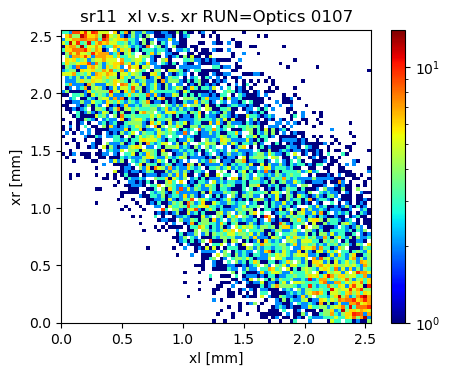

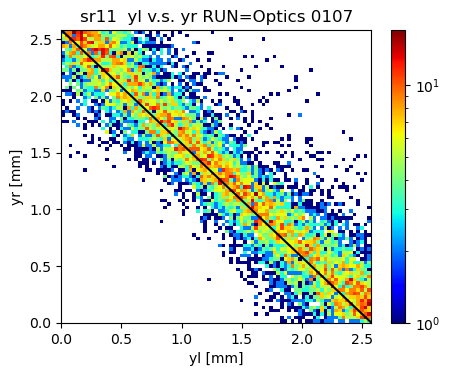

In [41]:
fig,ax=plt.subplots(figsize=(5,3.8))
H=ax.hist2d(xl,xr,bins=[np.linspace(0,3,100),np.linspace(0,3,100)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
#ax.plot(xl,xr,'.',color='red',markersize=1.2)
fig.colorbar(H[3],ax=ax)
#ax.plot((0,2.55),(2.55,0),color='black')
ax.set_xlabel("xl [mm]")
ax.set_ylabel("xr [mm]")
ax.set_title("sr11  xl v.s. xr RUN=Optics "+runname)
ax.set_xlim(0,2.55)
ax.set_ylim(0,2.55)
fig,ax=plt.subplots(figsize=(5,3.8))
H=ax.hist2d(yl,yr,bins=[np.linspace(0,3,100),np.linspace(0,3,100)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
#ax.plot(xl,xr,'.',color='red',markersize=1.2)
fig.colorbar(H[3],ax=ax)
ax.plot((0,2.58),(2.58,0),color='black')
ax.set_xlabel("yl [mm]")
ax.set_ylabel("yr [mm]")
ax.set_title("sr11  yl v.s. yr RUN=Optics "+runname)
ax.set_xlim(0,2.58)
ax.set_ylim(0,2.58)


# Fitting a Gaussian Distribution on the X-plane upstream of S1.
- Calculate the difference between xl and xr.
- Remove NaN and infinities.
- Limit to the range cut < diff_plane < cut only.
- Calculate of the Mean and Standard Deviation.
- Perform Gaussian distribution fitting.
- Plot it on a graph.

1.3155852989681782
フィット結果: mu = -0.0002, sigma = 0.2259


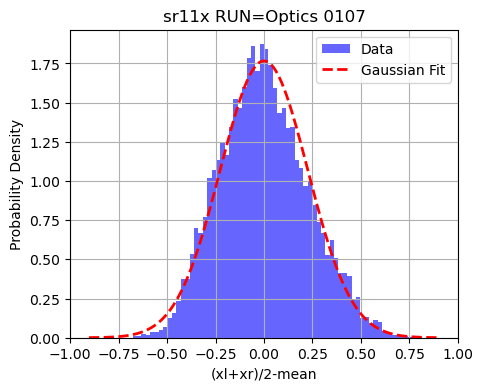

0.22589828060561168


In [42]:
from scipy.stats import norm
all_std=[]
cut=0.8
 # 差分計算
diff_plane = (xl +xr)/2
    
# NaNや無限大を除外
valid_diff_plane = diff_plane[np.isfinite(diff_plane)]
mean = np.mean(valid_diff_plane)
print(mean)
valid_diff_plane_shift=valid_diff_plane-mean

# cut < diff_plane < cut の範囲だけに絞る
diff_plane2 = valid_diff_plane_shift[(valid_diff_plane_shift > -cut) & (valid_diff_plane_shift < cut)]   
# 平均と標準偏差の計算
#mean = np.mean(diff_plane2)
std_val = np.std(diff_plane2, ddof=0)
all_std.append(std_val)
    
# ガウス分布のフィッティング
mu, sigma = norm.fit(diff_plane2)
print(f"フィット結果: mu = {mu:.4f}, sigma = {sigma:.4f}")
    
# グラフ作成
x_range_center = round(mu * 10) / 10  # muをベースにする
x_vals = np.linspace(x_range_center - 4 * sigma, x_range_center + 4 * sigma, 1000)
y_vals = norm.pdf(x_vals, mu, sigma)
    
fig, ax = plt.subplots(figsize=(5, 4))
n, bins, patches = ax.hist(diff_plane2, bins=100, range=(x_range_center - 5 * sigma, x_range_center + 5 * sigma), 
                        density=True, alpha=0.6, color='blue', label='Data')
ax.plot(x_vals, y_vals, 'r--', linewidth=2, label='Gaussian Fit')
ax.set_xlim(x_range_center - 1, x_range_center + 1)
plt.grid()
plt.legend()
plt.xlabel("(xl+xr)/2-mean")
plt.ylabel("Probability Density")
plt.title("sr11x RUN=Optics "+runname)
plt.show()
sigma_x=all_std[0]
print(all_std[0])

# Fitting a Gaussian Distribution on the Y-plane upstream of S1.
- Calculate the difference between yl and yr.
- Remove NaN and infinities.
- Limit to the range cut < diff_plane < cut only.
- Calculate of the Mean and Standard Deviation.
- Perform Gaussian distribution fitting.
- Plot it on a graph.

1.327834918775496
フィット結果: mu = -0.0019, sigma = 0.1293


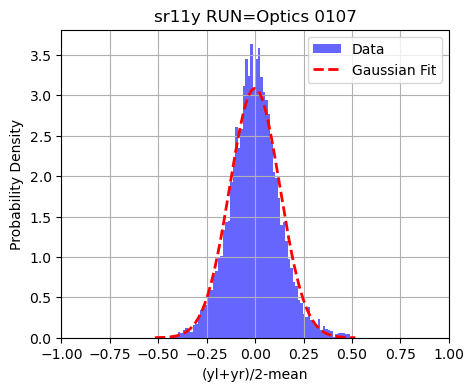

0.12928146554030037


In [43]:
all_std=[]
cut=0.5
 # 差分計算
diff_plane = (yl +yr)/2
    
# NaNや無限大を除外
valid_diff_plane = diff_plane[np.isfinite(diff_plane)]
mean = np.mean(valid_diff_plane)
print(mean)
valid_diff_plane_shift=valid_diff_plane-mean

# cut < diff_plane < cut の範囲だけに絞る
diff_plane2 = valid_diff_plane_shift[(valid_diff_plane_shift > -cut) & (valid_diff_plane_shift < cut)]   
# 平均と標準偏差の計算
#mean = np.mean(diff_plane2)
std_val = np.std(diff_plane2, ddof=0)
all_std.append(std_val)
    
# ガウス分布のフィッティング
mu, sigma = norm.fit(diff_plane2)
print(f"フィット結果: mu = {mu:.4f}, sigma = {sigma:.4f}")
    
# グラフ作成
x_range_center = round(mu * 10) / 10  # muをベースにする
x_vals = np.linspace(x_range_center - 4 * sigma, x_range_center + 4 * sigma, 1000)
y_vals = norm.pdf(x_vals, mu, sigma)
    
fig, ax = plt.subplots(figsize=(5, 4))
n, bins, patches = ax.hist(diff_plane2, bins=100, range=(x_range_center - 5 * sigma, x_range_center + 5 * sigma), 
                        density=True, alpha=0.6, color='blue', label='Data')
ax.plot(x_vals, y_vals, 'r--', linewidth=2, label='Gaussian Fit')
ax.set_xlim(x_range_center - 1, x_range_center + 1)
plt.grid()
plt.legend()
plt.xlabel("(yl+yr)/2-mean")
plt.ylabel("Probability Density")
plt.title("sr11y RUN=Optics "+runname)
plt.show()
sigma_x=all_std[0]
print(all_std[0])

# Convert the list of xq0l, xq0r, yq0l and yq0r of the downstream of S1.

In [44]:

converter = MonotoneTableConverter(half_cell_size=2.55)
read_list=["xq0l","xq0r"]
insdfs=df_xq0lr2

for i in read_list:
    file_path = "./prm/srppac/"+i+"_sr12_"+runname+".dat" # 読み込むファイルのパスを指定
    print(i)
    success = converter.load_text_file(file_path)
    if success:
        insdfs = converter.apply_to_spark_dataframe(insdfs, i,i)
        # --- 結果を表示 ---
    else : print("fail")
outdfsx=insdfs   

converter = MonotoneTableConverter(half_cell_size=2.58)
read_list=["yq0l","yq0r"]
insdfs=df_yq0lr2

for i in read_list:
    file_path = "./prm/srppac/"+i+"_sr12_"+runname+".dat" # 読み込むファイルのパスを指定
    print(i)
    success = converter.load_text_file(file_path)
    if success:
        insdfs = converter.apply_to_spark_dataframe(insdfs, i,i)
        # --- 結果を表示 ---
    else : print("fail")
outdfsy=insdfs   


xl=outdfsx.select(F.col("xq0l_dtl").getItem(0)).toPandas().values.flatten()
xr=outdfsx.select(F.col("xq0r_dtl").getItem(0)).toPandas().values.flatten()
yl=outdfsy.select(F.col("yq0l_dtl").getItem(0)).toPandas().values.flatten()
yr=outdfsy.select(F.col("yq0r_dtl").getItem(0)).toPandas().values.flatten()

xq0l
xq0r
yq0l
yq0r


# Plot xl vs. xr and yl vs. yr of the downstream of S1.
- xl/r is difference between Q0 and QL/R's TOT of X.
- yl/r is difference between Q0 and QL/R's TOT of Y.

(0.0, 2.58)

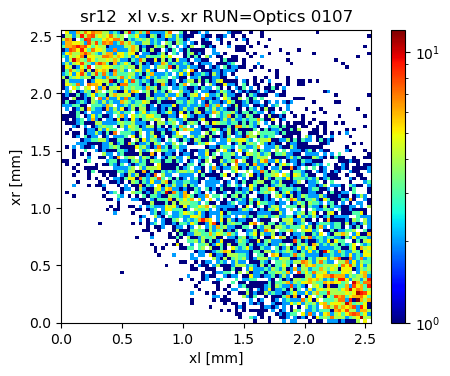

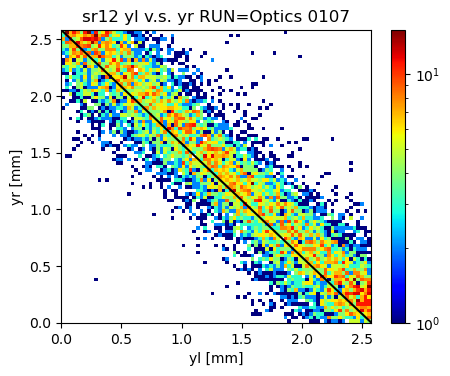

In [45]:
fig,ax=plt.subplots(figsize=(5,3.8))
H=ax.hist2d(xl,xr,bins=[np.linspace(0,3,100),np.linspace(0,3,100)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
#ax.plot(xl,xr,'.',color='red',markersize=1.2)
fig.colorbar(H[3],ax=ax)
#ax.plot((0,2.55),(2.55,0),color='black')
ax.set_xlabel("xl [mm]")
ax.set_ylabel("xr [mm]")
ax.set_title("sr12  xl v.s. xr RUN=Optics "+runname)
ax.set_xlim(0,2.55)
ax.set_ylim(0,2.55)
fig,ax=plt.subplots(figsize=(5,3.8))
H=ax.hist2d(yl,yr,bins=[np.linspace(0,3,100),np.linspace(0,3,100)],norm=matplotlib.colors.LogNorm(),cmap=cm.jet)
#ax.plot(xl,xr,'.',color='red',markersize=1.2)
fig.colorbar(H[3],ax=ax)
ax.plot((0,2.58),(2.58,0),color='black')
ax.set_xlabel("yl [mm]")
ax.set_ylabel("yr [mm]")
ax.set_title("sr12 yl v.s. yr RUN=Optics "+runname)
ax.set_xlim(0,2.58)
ax.set_ylim(0,2.58)

# Fitting a Gaussian Distribution on the X-plane downstream of S1.
- Calculate the difference between xl and xr.
- Remove NaN and infinities.
- Limit to the range cut < diff_plane < cut only.
- Calculate of the Mean and Standard Deviation.
- Perform Gaussian distribution fitting.
- Plot it on a graph.

1.318417531287887
フィット結果: mu = -0.0012, sigma = 0.2570


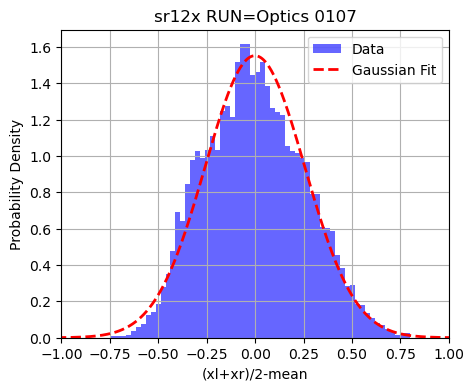

0.25702917827270555


In [46]:
from scipy.stats import norm
all_std=[]
cut=0.8
 # 差分計算
diff_plane = (xl +xr)/2
    
# NaNや無限大を除外
valid_diff_plane = diff_plane[np.isfinite(diff_plane)]
mean = np.mean(valid_diff_plane)
print(mean)
valid_diff_plane_shift=valid_diff_plane-mean

# cut < diff_plane < cut の範囲だけに絞る
diff_plane2 = valid_diff_plane_shift[(valid_diff_plane_shift > -cut) & (valid_diff_plane_shift < cut)]   
# 平均と標準偏差の計算
#mean = np.mean(diff_plane2)
std_val = np.std(diff_plane2, ddof=0)
all_std.append(std_val)
    
# ガウス分布のフィッティング
mu, sigma = norm.fit(diff_plane2)
print(f"フィット結果: mu = {mu:.4f}, sigma = {sigma:.4f}")
    
# グラフ作成
x_range_center = round(mu * 10) / 10  # muをベースにする
x_vals = np.linspace(x_range_center - 4 * sigma, x_range_center + 4 * sigma, 1000)
y_vals = norm.pdf(x_vals, mu, sigma)
    
fig, ax = plt.subplots(figsize=(5, 4))
n, bins, patches = ax.hist(diff_plane2, bins=100, range=(x_range_center - 5 * sigma, x_range_center + 5 * sigma), 
                        density=True, alpha=0.6, color='blue', label='Data')
ax.plot(x_vals, y_vals, 'r--', linewidth=2, label='Gaussian Fit')
ax.set_xlim(x_range_center - 1, x_range_center + 1)
plt.grid()
plt.legend()
plt.xlabel("(xl+xr)/2-mean")
plt.ylabel("Probability Density")
plt.title("sr12x RUN=Optics "+runname)
plt.show()
sigma_x=all_std[0]
print(all_std[0])

# Fitting a Gaussian Distribution on the Y-plane downstream of S1.
- Calculate the difference between yl and yr.
- Remove NaN and infinities.
- Limit to the range cut < diff_plane < cut only.
- Calculate of the Mean and Standard Deviation.
- Perform Gaussian distribution fitting.
- Plot it on a graph.

1.3313026602798768
フィット結果: mu = -0.0005, sigma = 0.1371


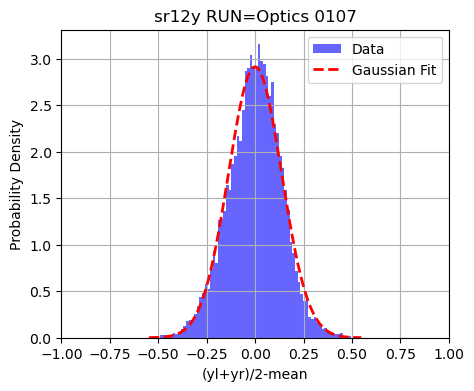

0.13706356497221103


In [47]:
all_std=[]
cut=0.5
 # 差分計算
diff_plane = (yl +yr)/2
    
# NaNや無限大を除外
valid_diff_plane = diff_plane[np.isfinite(diff_plane)]
mean = np.mean(valid_diff_plane)
print(mean)
valid_diff_plane_shift=valid_diff_plane-mean

# cut < diff_plane < cut の範囲だけに絞る
diff_plane2 = valid_diff_plane_shift[(valid_diff_plane_shift > -cut) & (valid_diff_plane_shift < cut)]   
# 平均と標準偏差の計算
#mean = np.mean(diff_plane2)
std_val = np.std(diff_plane2, ddof=0)
all_std.append(std_val)
    
# ガウス分布のフィッティング
mu, sigma = norm.fit(diff_plane2)
print(f"フィット結果: mu = {mu:.4f}, sigma = {sigma:.4f}")
    
# グラフ作成
x_range_center = round(mu * 10) / 10  # muをベースにする
x_vals = np.linspace(x_range_center - 4 * sigma, x_range_center + 4 * sigma, 1000)
y_vals = norm.pdf(x_vals, mu, sigma)
    
fig, ax = plt.subplots(figsize=(5, 4))
n, bins, patches = ax.hist(diff_plane2, bins=100, range=(x_range_center - 5 * sigma, x_range_center + 5 * sigma), 
                        density=True, alpha=0.6, color='blue', label='Data')
ax.plot(x_vals, y_vals, 'r--', linewidth=2, label='Gaussian Fit')
ax.set_xlim(x_range_center - 1, x_range_center + 1)
plt.grid()
plt.legend()
plt.xlabel("(yl+yr)/2-mean")
plt.ylabel("Probability Density")
plt.title("sr12y RUN=Optics "+runname)
plt.show()
sigma_x=all_std[0]
print(all_std[0])